In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set()

C:\Users\Administrator\AppData\Roaming\SPB_Data\.conda\envs\ft\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read Data

In [2]:
file = "0050.TW-long.csv"
data = pd.read_csv(file)
data.index = pd.to_datetime(data.Date)
close = data["Adj Close"]

# Strategy

In [3]:
def ema_strategy(adj_close, N):
    ma = adj_close.rolling(N).mean()
    ema = adj_close.ewm(span = N, adjust=False).mean()
    
    signal = pd.Series(np.nan, adj_close.index)
    signal[ema > ma] = True
    signal[(ema < ma) & (adj_close < ema)] = False
    
    signal = signal.ffill().shift(1)[1:]
    daily_returns = adj_close.pct_change()[1:]
    strategy_daily_returns = (signal * daily_returns).dropna()
    
    return strategy_daily_returns

In [4]:
N = 26
ma = close.rolling(N).mean()
ema = close.ewm(span = N, adjust=False).mean()

buy_condition = ema > ma
sell_condition = (ema < ma) & (close < ema)

entry_signal = pd.Series([np.nan]*len(buy_condition), index = buy_condition.index)
exit_signal = pd.Series([np.nan]*len(sell_condition), index = sell_condition.index)

position = 0
for i in range(0, len(buy_condition) - 1):
    if position == 0:
        if buy_condition[i]:
            position = 1
            entry_signal[i] = close[i]
            
    elif position == 1:        
        if sell_condition[i]:
            position = 0
            exit_signal[i] = close[i]

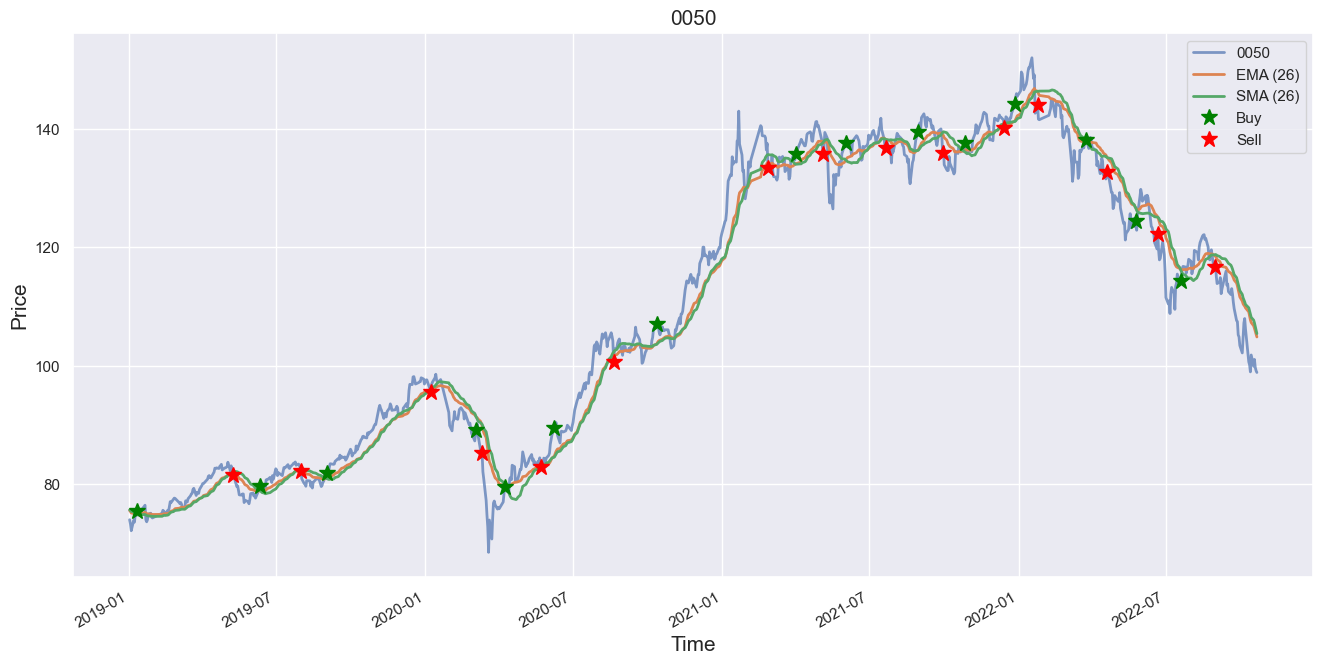

In [5]:
fig, ax = plt.subplots(figsize = (16, 8))
close["2019":].plot(ax = ax, label = "0050", lw = 2, alpha = 0.7)
ema["2019":].plot(ax = ax, label = "EMA (26)", lw = 2)
ma["2019":].plot(ax = ax, label = "SMA (26)", lw = 2)
entry_signal.dropna()["2019":].plot(style='*', color = "green", label = "Buy", markersize = 12)
exit_signal.dropna()["2019":].plot(style='*', color = "red", label = "Sell", markersize = 12)

ax.legend()

ax.set_title("0050", fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel("Price", fontsize = 15)
plt.show()

# Optimization

In [6]:
def get_parameter_pool(metric, range_threshold, metric_threshold):
    max_value = -np.inf
    max_value_index = None
    
    param_range = list(metric.index)
    for i in param_range:
        step = int(round(range_threshold * i, 0))
        
        metric_value = metric[(metric.index >= i - step) & (metric.index <= i + step)]
        beyond_threshold = (metric_value > metric.loc[i] * (1 - metric_threshold)).all()
        
        if beyond_threshold and metric[i] > max_value:
            max_value = metric[i]
            max_value_index = i
            
    return max_value_index

def sharpe_ratio(daily_returns):
    temp = daily_returns.dropna()
    return temp.mean() / temp.std() * np.sqrt(252)

def sortino_ratio(daily_returns):
    temp = daily_returns.dropna()
    return temp.mean() / temp[temp < 0].std() * np.sqrt(252)

def annualized_return(daily_returns):
    temp = daily_returns.dropna()
    total_year = ((temp.index[-1] - temp.index[0]).total_seconds()) / (365 * 24 * 3600)
    return (temp + 1).prod() ** (1/total_year) - 1

def annualized_volatility(daily_returns):
    temp = daily_returns.dropna()
    return temp.std() * np.sqrt(252)

def mdd(daily_returns):
    temp = daily_returns.dropna()
    cum = (temp + 1).cumprod()
    return (cum/cum.cummax() - 1).min()
    
def risk_reward_ratio(daily_returns):
    temp = daily_returns.dropna()
    m = mdd(daily_returns)
    return ((temp + 1).prod() - 1) / abs(m)

In [7]:
strategy_daily_returns_dict = {}
close_insample = close["2010":"2018"]

for N in range(5, 50+1):
    strategy_daily_returns_dict[N] = ema_strategy(close_insample, N)
    
op_results = pd.DataFrame(strategy_daily_returns_dict)

In [8]:
op_sharpes = op_results.apply(sharpe_ratio)
op_sortinos = op_results.apply(sortino_ratio)
op_ar = op_results.apply(annualized_return)
op_rrr = op_results.apply(risk_reward_ratio)

In [9]:
range_threshold, metric_threshold = 0.05, 0.05
best_param_sharpe = get_parameter_pool(op_sharpes, range_threshold, metric_threshold)
best_param_sortino = get_parameter_pool(op_sortinos, range_threshold, metric_threshold)
best_param_ar = get_parameter_pool(op_ar, range_threshold, metric_threshold)
best_param_rrr = get_parameter_pool(op_rrr, range_threshold, metric_threshold)

In [10]:
print(best_param_sharpe, best_param_sortino, best_param_ar, best_param_rrr)

26 27 26 27


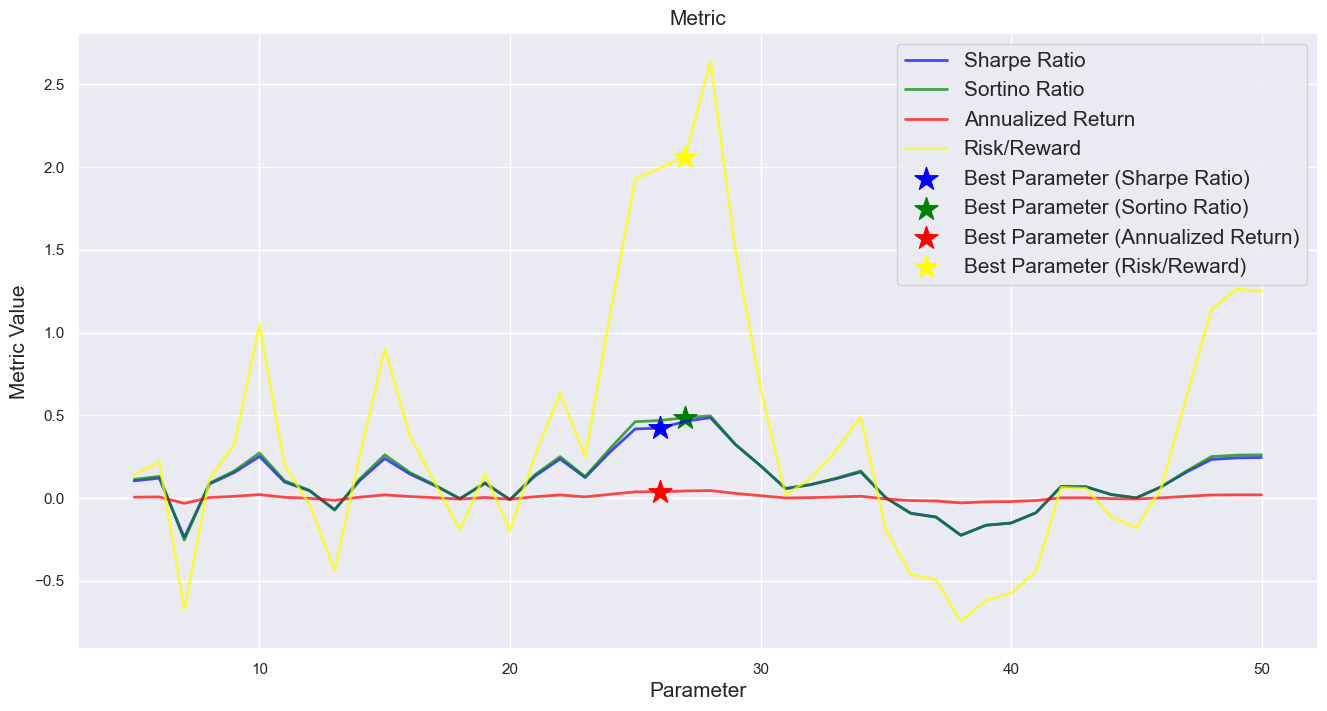

In [11]:
fig, ax = plt.subplots(figsize = (16, 8))

op_sharpes.plot(ax = ax, lw = 2, color = "blue", label = "Sharpe Ratio", alpha = 0.7)
op_sortinos.plot(ax = ax, lw = 2, color = "green", label = "Sortino Ratio", alpha = 0.7)
op_ar.plot(ax = ax, lw = 2, color = "red", label = "Annualized Return", alpha = 0.7)
op_rrr.plot(ax = ax, lw = 2, color = "yellow", label = "Risk/Reward", alpha = 0.7)

ax.scatter(best_param_sharpe, op_sharpes[best_param_sharpe], color = "blue", marker = "*", s = 300, label = "Best Parameter (Sharpe Ratio)")
ax.scatter(best_param_sortino, op_sortinos[best_param_sortino], color = "green", marker = "*", s = 300, label = "Best Parameter (Sortino Ratio)")
ax.scatter(best_param_ar, op_ar[best_param_ar], color = "red", marker = "*", s = 300, label = "Best Parameter (Annualized Return)")
ax.scatter(best_param_rrr, op_rrr[best_param_rrr], color = "yellow", marker = "*", s = 300, label = "Best Parameter (Risk/Reward)")

ax.set_title("Metric", fontsize = 15)
ax.set_xlabel('Parameter', fontsize = 15)
ax.set_ylabel("Metric Value", fontsize = 15)

plt.legend(fontsize = 15)
plt.show()

# 樣本內外績效

In [12]:
def overall_performance(returns, labels):
    results = {}
    for re, label in zip(returns, labels):
        re = re.dropna()
        total_year = ((re.index[-1] - re.index[0]).total_seconds()) / (365 * 24 * 3600)
        annualized_return = (re + 1).prod() ** (1/total_year) - 1
        annualized_volatility = re.std() * np.sqrt(252)
        sharpe_ratio = re.mean() / re.std() * np.sqrt(252)
        
        cumprod_return = (re + 1).cumprod()
        mdd = (cumprod_return / cumprod_return.cummax() - 1).min()
        
        results[label] = [annualized_return, annualized_volatility, sharpe_ratio, mdd]
        
    results = pd.DataFrame(results).T
    results.columns = ["Annualized Return", "Annualized Volatility", "Sharpe Ratio", "MDD"]
    
    return results

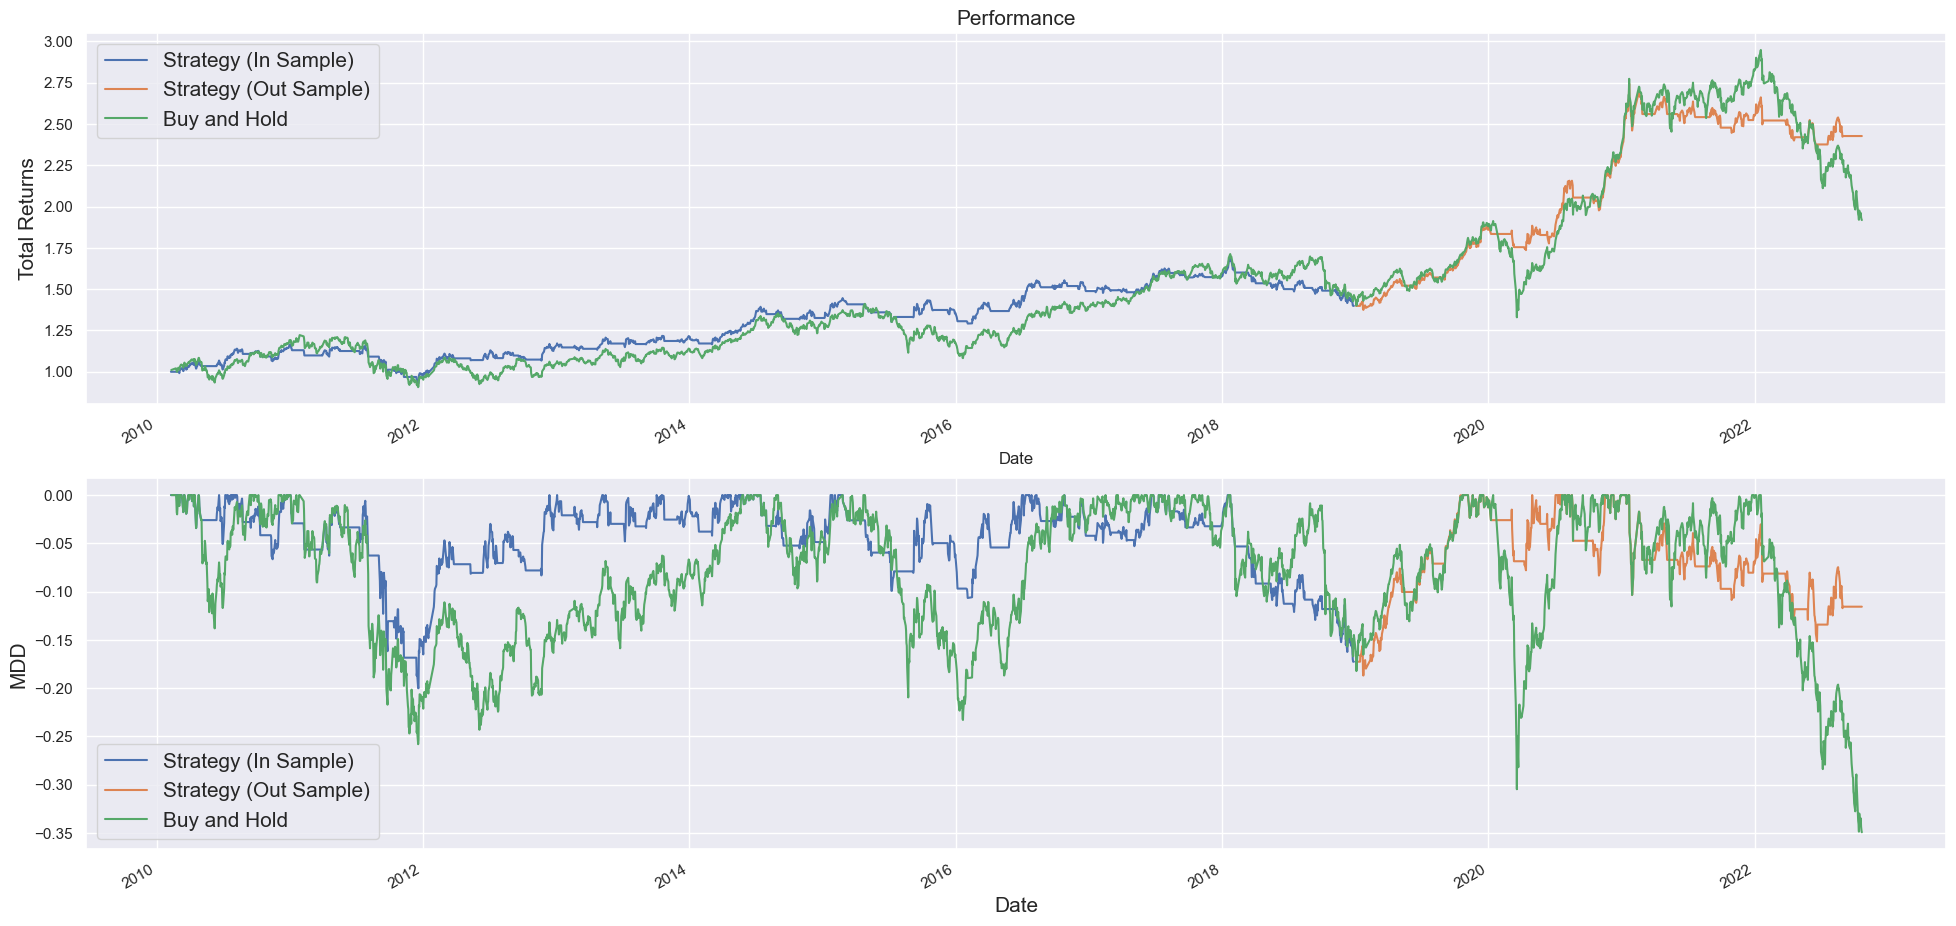

In [13]:
N = 26
close_outsample = close[close_insample.index[-N]:]

strategy_daily_returns_insample = ema_strategy(close_insample, N)
strategy_daily_returns_outsample = ema_strategy(close_outsample, N)

cum_insample = (strategy_daily_returns_insample + 1).cumprod()
cum_outsample = (strategy_daily_returns_outsample + 1).cumprod()

fig, ax = plt.subplots(2, figsize = (24, 12))
cum_insample.plot(ax = ax[0], label = "Strategy (In Sample)")
(cum_outsample * cum_insample.iloc[-1]).plot(ax = ax[0], label = "Strategy (Out Sample)")

benckmark = close[strategy_daily_returns_insample.index[0]:strategy_daily_returns_outsample.index[-1]]
benckmark_daily_returns = benckmark.pct_change()[1:]
cum_benckmark = (benckmark_daily_returns + 1).cumprod()
cum_benckmark.plot(ax = ax[0], label = "Buy and Hold")


ax[0].set_title("Performance", fontsize = 15)
ax[0].set_ylabel('Total Returns', fontsize = 15)
ax[0].legend(fontsize = 15)

cum_in_out = pd.concat([cum_insample, cum_outsample * cum_insample.iloc[-1]])
mdd_in_out = (cum_in_out / cum_in_out.cummax() - 1)
mdd_in_out[:"2018"].plot(ax = ax[1], label = "Strategy (In Sample)")
mdd_in_out["2019":].plot(ax = ax[1], label = "Strategy (Out Sample)")

mdd_benckmark = (cum_benckmark / cum_benckmark.cummax() - 1)
mdd_benckmark.plot(ax = ax[1], label = "Buy and Hold")

ax[1].set_xlabel('Date', fontsize = 15)
ax[1].set_ylabel('MDD', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [51]:
returns = [strategy_daily_returns_insample, benckmark_daily_returns[strategy_daily_returns_insample.index[0]:strategy_daily_returns_insample.index[-1]],
           strategy_daily_returns_outsample, benckmark_daily_returns[strategy_daily_returns_outsample.index[0]:strategy_daily_returns_outsample.index[-1]]]

labels = ["Strategy (In Sample)", "Buy and Hold (In Sample Period)", "Strategy (Out Sample)", "Buy and Hold (Out Sample Period)"]
overall_performance(returns, labels)

,Annualized Return,Annualized Volatility,Sharpe Ratio,MDD
Strategy (In Sample),0.038499,0.104172,0.422234,-0.200119
Buy and Hold (In Sample Period),0.043882,0.154353,0.361383,-0.258095
Strategy (Out Sample),0.156076,0.129057,1.229389,-0.151554
Buy and Hold (Out Sample Period),0.079124,0.194801,0.502553,-0.349342


# 均線統計分析

C:\Users\Administrator\AppData\Roaming\SPB_Data\.conda\envs\ft\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrator\AppData\Roaming\SPB_Data\.conda\envs\ft\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


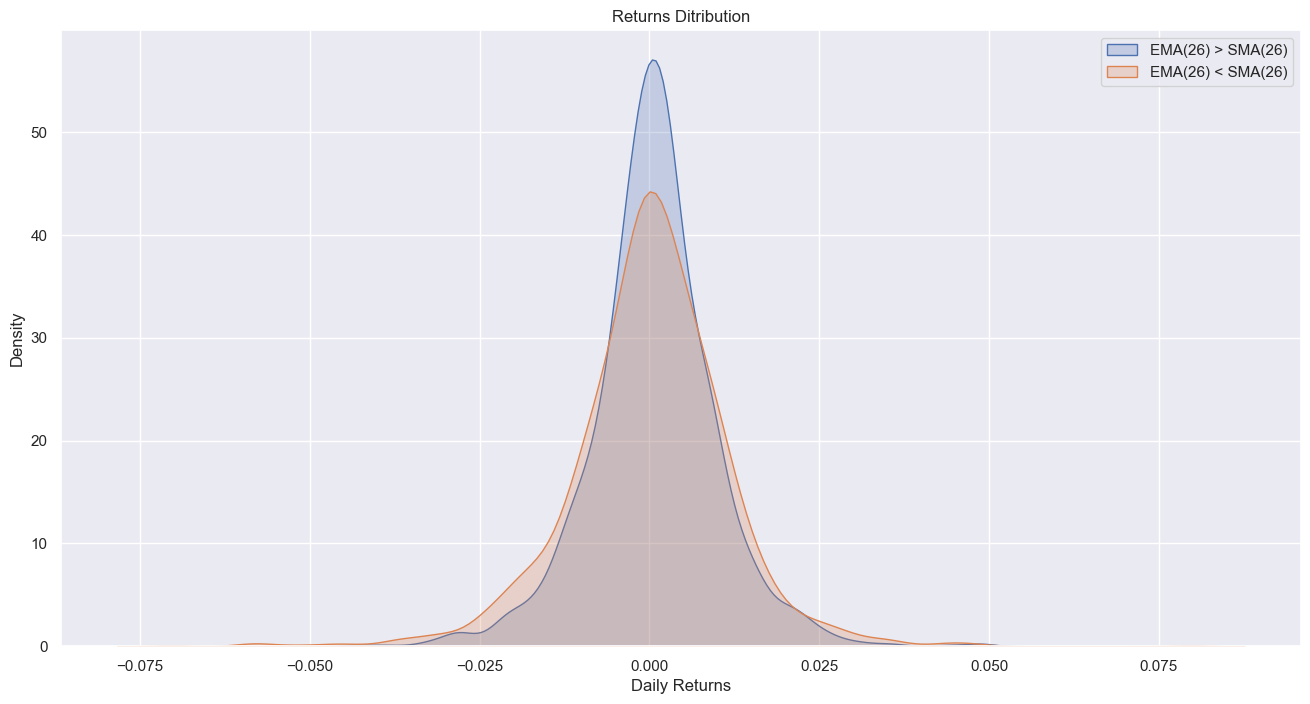

In [15]:
def plot_distribution(returns, labels):
    for data, label in zip(returns, labels):
        figure = sns.distplot(data, hist = False, label = label, kde_kws={"shade": True, 'cumulative': False})
        figure.set_title("Returns Ditribution")
        figure.set_ylabel("Density")
        figure.set_xlabel("Daily Returns")
    
    plt.legend()
    plt.show()
    
plt.rcParams['figure.figsize'] = (16, 8)
ma = close.rolling(N).mean()
ema = close.ewm(span = N, adjust=False).mean()
daily_returns = close.pct_change()[1:]

daily_returns_bull = daily_returns[(ema > ma).shift(1)[1:]]
daily_returns_bear = daily_returns[(ema < ma).shift(1)[1:]]
plot_distribution([daily_returns_bull, daily_returns_bear], ["EMA(26) > SMA(26)", "EMA(26) < SMA(26)"])

In [16]:
ks_tws = stats.kstest(daily_returns_bull, daily_returns_bear, alternative = "two-sided")
ks_less = stats.kstest(daily_returns_bull, daily_returns_bear, alternative = "less")
ks_greater = stats.kstest(daily_returns_bull, daily_returns_bear, alternative = "greater")

In [17]:
print(ks_tws)
print(ks_less)
print(ks_greater)

KstestResult(statistic=0.06682414762915084, pvalue=0.0018133234166662904)
KstestResult(statistic=0.06682414762915084, pvalue=0.0008843022705768179)
KstestResult(statistic=0.04380684528214997, pvalue=0.048000480483325024)


# 策略穿透性

In [47]:
data = pd.read_csv("50_member_adj_close.txt", encoding = 'ANSI', sep = ",", low_memory=False)
data["年月日"] = pd.to_datetime(data["年月日"], format = '%Y%m%d')
data_pivot = data.pivot(index = "年月日", columns = "證券代碼")
mem_adj_close = data_pivot["收盤價(元)"]
mem_adj_close.index.name = "Date"
mem_returns = mem_adj_close.pct_change()[1:]

In [48]:
mem_strategy_daily_returns = mem_adj_close.apply(ema_strategy, args = (N, )).mean(axis = 1)
mem_bnh_daily_returns = mem_returns.mean(axis = 1)

cum_mem_strategy = (mem_strategy_daily_returns + 1).cumprod()
cum_mem_bnh = (mem_bnh_daily_returns + 1).cumprod()

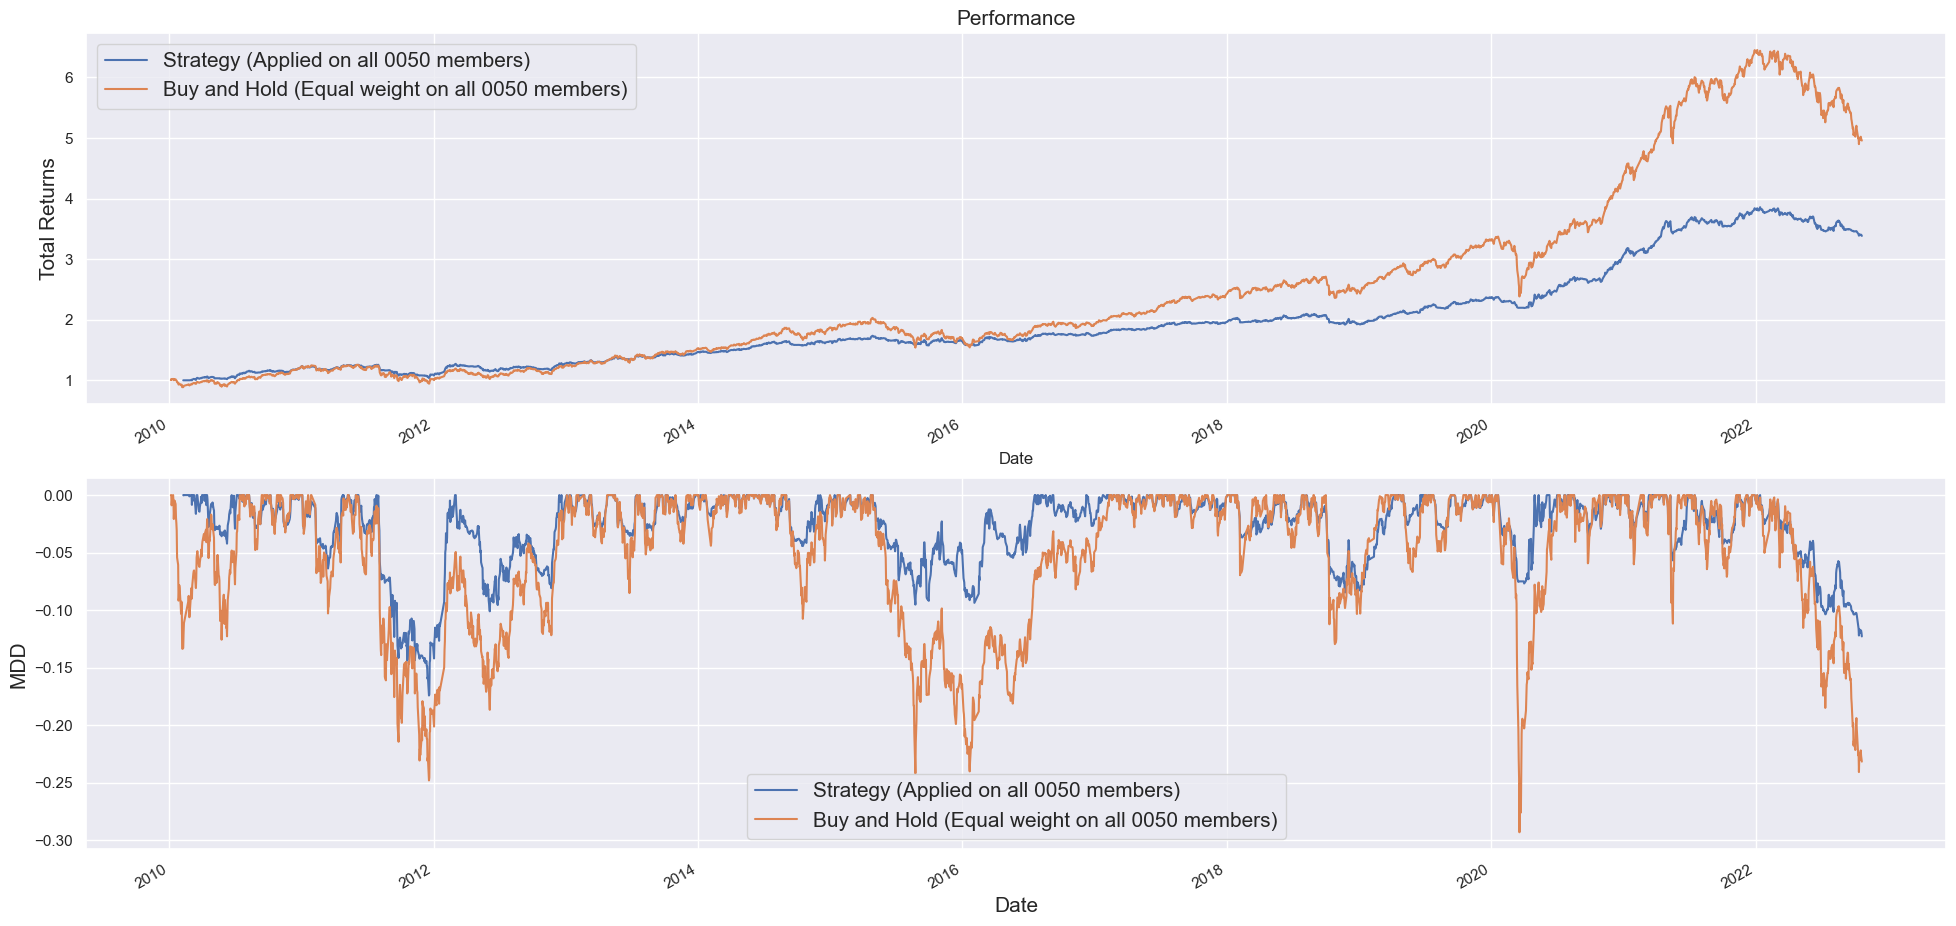

In [49]:
fig, ax = plt.subplots(2, figsize = (24, 12))
cum_mem_strategy.plot(ax = ax[0], label = "Strategy (Applied on all 0050 members)")
cum_mem_bnh.plot(ax = ax[0], label = "Buy and Hold (Equal weight on all 0050 members)")


ax[0].set_title("Performance", fontsize = 15)
ax[0].set_ylabel('Total Returns', fontsize = 15)
ax[0].legend(fontsize = 15)

mdd_mem_strategy = (cum_mem_strategy / cum_mem_strategy.cummax() - 1)
mdd_mem_strategy.plot(ax = ax[1], label = "Strategy (Applied on all 0050 members)")
mdd_mem_bnh = (cum_mem_bnh / cum_mem_bnh.cummax() - 1)
mdd_mem_bnh.plot(ax = ax[1], label = "Buy and Hold (Equal weight on all 0050 members)")

ax[1].set_xlabel('Date', fontsize = 15)
ax[1].set_ylabel('MDD', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [54]:
returns = [mem_strategy_daily_returns, mem_bnh_daily_returns]

labels = ["Strategy (Applied on all 0050 members)", "Buy and Hold (Equal weight on all 0050 members)"]
overall_performance(returns, labels)

,Annualized Return,Annualized Volatility,Sharpe Ratio,MDD
Strategy (Applied on all 0050 members),0.100663,0.091452,1.120972,-0.174290
Buy and Hold (Equal weight on all 0050 members),0.133211,0.159513,0.883230,-0.293195
